In [12]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path 
import sys 

from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import shap
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import rr, prep, var_dict, audit, plot, save
import os 

%load_ext autoreload
%autoreload 2

shap.initjs()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived  = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived  = '/Users/alina/Desktop/MIT/code/data/output/derived_data'

info_path = Path(data_root, "files")
#os.listdir(data_derived)


### do te variable extraction again 

In [14]:
types = pd.read_csv(Path(data_derived, 'mta_data_clean_types.csv'), usecols=['Variable', 'Type'])

cat_vars = [var for var in types['Variable'] if 'cat' in types.loc[types['Variable'] == var, 'Type'].values] # categorical variables
num_vars = [var for var in types['Variable'] if 'num' in types.loc[types['Variable'] == var, 'Type'].values] # numerical variables 
ord_vars = [var for var in types['Variable'] if 'ord' in types.loc[types['Variable'] == var, 'Type'].values] #ordinal variables 
print(cat_vars)
print(num_vars)



['cbcl_academic_m', 'cbcl_academic_f', 'cbcl_special_ed_m', 'cbcl_repeat_grade_m', 'cbcl_academic_m', 'cbcl_special_ed_f', 'cbcl_repeat_grade_f', 'cbcl_academic_f', 'trtname']
['expect_exptott_m', 'expect_exptott_f', 'wiat_w1readb_c', 'wiat_w2math_c', 'wiat_w3spell_c', 'masc_masc_physicaltenset_c', 'masc_masc_physicalsomatict_c', 'masc_masc_physicaltotalt_c', 'masc_masc_harmavoidperfectionismt_c', 'masc_masc_harmavoidanxiouscopingt_c', 'masc_masc_socialhumiliationt_c', 'masc_masc_socialperformancet_c', 'masc_masc_socialtotalt_c', 'masc_masc_separationpanict_c', 'masc_masc_masctotalt_c']


In [15]:
################## PREDICTORS ####################
pred = pd.read_csv(Path(data_derived, 'mta_data_clean.csv')).drop(columns = 'Unnamed: 0')
single_rater_pred = None # if set to None use all raters 

for col in pred.columns:
    if col not in cat_vars and col not in num_vars and col not in ord_vars:
        print(col)

src_subject_id
masc_ma7_c
masc_ma16_c
masc_ma18_c
masc_ma22_c
masc_ma23_c
masc_ma31_c
masc_ma12sax_c
masc_ma21px_c
masc_ma22acx_c
masc_ma31hfx_c
masc_ma32pfx_c
masc_ma1phyx_c
masc_ma2hat_c
masc_ma3socx_c
masc_ma4sepx_c
masc_matotalx_c
snap_sna19_m
snap_sna20_m
snap_sna21_m
snap_sna22_m
snap_sna23_m
snap_sna24_m
snap_sna25_m
snap_sna26_m
snap_sna27_m
snap_sna28_m
snap_sna29_m
snap_sna30_m
snap_sna31_m
snap_sna32_m
snap_sna33_m
snap_sna34_m
snap_sna35_m
snap_sna36_m
snap_sna37_m
snap_sna38_m
snap_sna39_m
snap_snainatt_m
snap_snahypat_m
snap_snaimput_m
snap_snaaddwt_m
snap_snaoddt_m
snap_snatotlt_m
snap_snahyimx_m
snap_snaadhdt_m
snap_snahit_m
snap_snadbdx_m
snap_snap_adhd_1_f
snap_snap_adhd_2_f
snap_snap_adhd_3_f
snap_snap_adhd_4_f
snap_snap_adhd_5_f
snap_snap_adhd_6_f
snap_snap_adhd_7_f
snap_snap_adhd_8_f
snap_snap_adhd_9_f
snap_snap_adhd_11_f
snap_snap_adhd_12_f
snap_snap_adhd_13_f
snap_snap_adhd_14_f
snap_snap_adhd_15_f
snap_snap_adhd_16_f
snap_snap_adhd_17_f
snap_snap_adhd_18_f
snap_

In [16]:

if single_rater_pred is not None:
    col_pred = [ col for col in pred.columns if col.endswith(single_rater_pred)]
    col_pred.append("src_subject_id")
    col_pred.append('trtname')
    pred = pred[col_pred]
    
    
 ################ OUTCOMES ##################   
out = pd.read_csv(Path(data_derived, 'out_clean_all_raters.csv')).drop(columns = 'Unnamed: 0')
rater_out = 'm'
col_out_rater = [col for col in out if col.endswith(rater_out)]

out_rater = out[np.concatenate((['src_subject_id'], col_out_rater))]

for col in col_out_rater:
    print(col, out_rater[col].dropna().shape)

out_rater = out_rater.rename(columns={col: f"{col}_out" for col in out_rater.columns if col != 'src_subject_id'})


################ MERGE ##############
data = pd.merge(out_rater, pred, how = 'left', on = 'src_subject_id')

y_cols = [col for col in data.columns if col.endswith('out')]
y_col = y_cols[0] # extrcat single outcome to predict 
print('To predict : ', y_col)

X_cols = [col for col in data.columns if col not in y_cols]
data = data.dropna(subset=[y_col])

y = np.array(data[y_col])
X = data[X_cols].drop(columns='src_subject_id')


snap_snainatt_m (502,)
snap_snahypat_m (503,)
snap_snaoddt_m (503,)
ssrs_sspintt_m (497,)
ssrs_ssptosst_m (496,)
pcrc_pcrcpax_m (520,)
pcrc_pcrcprx_m (521,)
To predict :  snap_snainatt_m_out


In [70]:
col_names_data = list(data.columns)
col_names_data


['src_subject_id',
 'snap_snainatt_m_out',
 'snap_snahypat_m_out',
 'snap_snaoddt_m_out',
 'ssrs_sspintt_m_out',
 'ssrs_ssptosst_m_out',
 'pcrc_pcrcpax_m_out',
 'pcrc_pcrcprx_m_out',
 'expect_exp1_m',
 'expect_exp2_m',
 'expect_exp3_m',
 'expect_exp4_m',
 'expect_exp5_m',
 'expect_exp6_m',
 'expect_exptott_m',
 'expect_exp1_f',
 'expect_exp2_f',
 'expect_exp3_f',
 'expect_exp4_f',
 'expect_exp5_f',
 'expect_exp6_f',
 'expect_exptott_f',
 'masc_masc_p_1_c',
 'masc_masc_p_2_c',
 'masc_masc_p_3_c',
 'masc_masc_p_4_c',
 'masc_masc_p_5_c',
 'masc_masc_p_6_c',
 'masc_masc_p_7_c',
 'masc_masc_p_8_c',
 'masc_masc_p_9_c',
 'masc_masc_p_10_c',
 'masc_masc_p_11_c',
 'masc_masc_p_12_c',
 'masc_masc_p_13_c',
 'masc_masc_p_14_c',
 'masc_masc_p_15_c',
 'masc_masc_p_16_c',
 'masc_masc_p_17_c',
 'masc_masc_p_18_c',
 'masc_masc_p_19_c',
 'masc_masc_p_20_c',
 'masc_masc_p_21_c',
 'masc_masc_p_22_c',
 'masc_masc_p_23_c',
 'masc_masc_p_24_c',
 'masc_masc_p_25_c',
 'masc_masc_p_26_c',
 'masc_masc_p_27_c',
 

In [72]:
types_df =  pd.read_excel(Path(data_derived, 'all_vars_description_ML.xlsx'), sheet_name='Sheet1')

for i, var in enumerate(types_df.iterrows()):
    qst = var[1][0]
    var_name = var[1][1]

    
    var_name = "_".join([var[1][0],var[1][1]] )
    
    type_ = var[1][4]
    var_in_data = [ col for col in col_names_data if col.startswith(var_name)]
    print(var_in_data)

['snap_sna19_m', 'snap_sna19_f', 'snap_sna19_t']
['snap_sna20_m', 'snap_sna20_f', 'snap_sna20_t']
['snap_sna21_m', 'snap_sna21_f', 'snap_sna21_t']
['snap_sna22_m', 'snap_sna22_f', 'snap_sna22_t']
['snap_sna23_m', 'snap_sna23_f', 'snap_sna23_t']
['snap_sna24_m', 'snap_sna24_f', 'snap_sna24_t']
['snap_sna25_m', 'snap_sna25_f', 'snap_sna25_t']
['snap_sna26_m', 'snap_sna26_f', 'snap_sna26_t']
['snap_sna27_m', 'snap_sna27_f', 'snap_sna27_t']
['snap_sna28_m', 'snap_sna28_f', 'snap_sna28_t']
['snap_sna29_m', 'snap_sna29_f', 'snap_sna29_t']
['snap_sna30_m', 'snap_sna30_f', 'snap_sna30_t']
['snap_sna31_m', 'snap_sna31_f', 'snap_sna31_t']
['snap_sna32_m', 'snap_sna32_f', 'snap_sna32_t']
['snap_sna33_m', 'snap_sna33_f', 'snap_sna33_t']
['snap_sna34_m', 'snap_sna34_f', 'snap_sna34_t']
['snap_sna35_m', 'snap_sna35_f', 'snap_sna35_t']
['snap_sna36_m', 'snap_sna36_f', 'snap_sna36_t']
['snap_sna37_m', 'snap_sna37_f', 'snap_sna37_t']
['snap_sna38_m', 'snap_sna38_f', 'snap_sna38_t']
['snap_sna39_m', 'sn

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_85964/373487558.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qst = var[1][0]
/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_85964/373487558.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_name = var[1][1]
/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_85964/373487558.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_name = "_".joi

In [22]:
cols = [ col for col in data.columns if col.startswith("scid_q021_mdd_life")]
cols

['scid_q021_mdd_life_m', 'scid_q021_mdd_life_f']

In [24]:
data['scid_q021_mdd_life_m'].unique()

array([ 2.,  3.,  1., nan,  0.])

In [6]:
pred['expect_exptott_m'].unique()

array([36. , 44. , 38. ,  6. , 41. , 16. , 17. , 18. , 35. , 34. , 12. ,
       26. ,  nan, 39. , 22. , 43. , 15. , 31. , 55. , 37. , 33. , 40. ,
       29. , 14. , 25. , 19. , 47. , 20. , 11. , 48. , 30. , 21. ,  9. ,
       28. , 32. , 27. , 60. , 54. , 13. , 23. , 52. ,  7. , 50. , 24. ,
       42. , 10. , 46. , 53. , 58. , 45. , 51. ,  8. , 33.6, 49. , 56. ,
       27.6])

In [7]:
# Define the extensions to check
extensions = ['_m', #mother 
              #'_p'# proffesionals
              '_f', # father,
              '_c',# child,
              '_t'] # teacher 

# Count columns for each extension
extension_counts = {ext: sum(col.endswith(ext) for col in pred.columns) for ext in extensions}

for ext, count in extension_counts.items():
    print(f"Columns ending with '{ext}': {count}")

Columns ending with '_m': 277
Columns ending with '_f': 228
Columns ending with '_c': 68
Columns ending with '_t': 138


In [8]:
qsts = set([var.split('_')[0] for var in pred.columns])
qsts.remove('src')
qsts.remove('trtname')
qsts

{'cbcl', 'expect', 'masc', 'pcrc', 'scid', 'snap', 'ssrs', 'wiat'}

# Select specifix rater for outcome to predict 
- Chose mother because more data avialable than father 
- more accurate than teacher ? read in litt 
- merge just to make sure the subjects and indices work

### For num vars, dont anything because tree based models are not scale sensitive 
For other models, consider scaling num vars with StandardScaler 


In [9]:
params = { 'tune_hyperparam' : False, 
          'temp_size' : 0.2,
          'test_size' : 0.2,
          'random_state' : 42, 
          'num_top_features': 10,}

In [11]:
tune_hyperparam = False

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=params['temp_size'], random_state=params['random_state'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = params['test_size'], random_state=params['random_state'])

print('TRAIN ', X_train.shape, y_train.shape)
print('VAL', X_val.shape, y_val.shape)
print('TEST', X_test.shape, y_test.shape)

num_top_features = params['num_top_features'] # how many features to extract 

#################### FETAURE SELECTION #################################

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_vars) ########### what varibale to encode how need to be checked again
    ],
    remainder='passthrough'  # Keep numerical columns as they are
)

# Pipeline for featrues selection 
pipeline_fs = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=params['random_state']))
])



pipeline_fs.fit(X_train, y_train)
best_pipeline = pipeline_fs

preprocessor = pipeline_fs.named_steps["preprocessor"]
model = pipeline_fs.named_steps["model"]


X_train_transformed = preprocessor.transform(X_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed) 

# Aggregate SHAP values to get feature importance
shap_importance = np.abs(shap_values).mean(axis=0)

# Rank features by importance
feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': shap_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False) 

# Select top features 

top_features = importance_df['Feature'].head(params['num_top_features']).tolist() ########### EXTRACT 10 TOP FEATURES 
print("Top features", top_features)

# Filter dataset for top features
X_train_selected = pd.DataFrame(X_train_transformed, columns=feature_names).loc[:, top_features] # extract 

X_val_transformed = preprocessor.transform(X_val)
X_val_selected = pd.DataFrame(X_val_transformed, columns=feature_names).loc[:, top_features]

X_test_transformed = preprocessor.transform(X_test)
X_test_selected = pd.DataFrame(X_test_transformed, columns=feature_names).loc[:, top_features]


####################### PREDICT  ############################

pipeline_predict = Pipeline([
    #('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

  ################################### HYPERPARAMS ################
if params['tune_hyperparam'] : 
    param_dist = {
        'model__n_estimators': randint(100, 300),
        'model__learning_rate': uniform(0.01, 0.1),
        'model__max_depth': randint(3, 10)
    }
    best_pipeline_predict = RandomizedSearchCV(
        pipeline_predict, param_dist, n_iter=50, cv=5, scoring='r2', random_state=42, n_jobs=-1
)
else:
    # Use standard hyperparameters and perform cross-validation
    pipeline_predict = Pipeline([
        ('model', XGBRegressor(random_state=42))  # Use default hyperparameters
    ])

    # Perform cross-validation
    cv_folds = 5  # Number of cross-validation folds
    cv_scores = cross_val_score(pipeline_predict, X_train_selected, y_train, 
                                cv=cv_folds, scoring='r2', n_jobs=-1)

    # Print cross-validation results
    print(f"Cross-validated R^2 scores: {cv_scores}")
    print(f"Mean R^2 score: {cv_scores.mean()}")

    # Fit the model on the entire training data
    pipeline_predict.fit(X_train_selected, y_train)
    best_pipeline_predict = pipeline_predict  # Assign the fitted pipeline
    
######################### FTT ############
best_pipeline_predict.fit(X_train_selected, y_train)
val_score = best_pipeline_predict.score(X_val_selected, y_val)
print("Validation R^2 Score:", val_score)




TRAIN  (401, 712) (401,)
VAL (80, 712) (80,)
TEST (21, 712) (21,)


ValueError: could not convert string to float: 'White, not of Hispanic origin'

In [ ]:

######################### EVALUATE #######################

y_pred = best_pipeline_predict.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error after feature selection:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error after feature selection:", rmse)


In [392]:
X_train_selected.shape
#y_train.shape

(399, 10)

In [293]:
preprocessor

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['scid_ethnic_group_m', 'scid_das1ms_m',
                                  'trtname'])])

In [ ]:
grid_search = True
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_vars_totransform)
    ],
    remainder='passthrough'  # Keep numerical columns as they are
)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

# Perform grid search
if grid_search:
    print("PERFORMING GRID SEARCH ..")
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [-1, 3, 5, 7],  # -1 means no limit in LightGBM
        'model__num_leaves': [31, 50, 70]   # Specific to LightGBM
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best R2 Score:", grid_search.best_score_)
    
    # Use the best estimator for SHAP analysis
    best_pipeline = grid_search.best_estimator_
else:

    print("NO GRID SEARCH ..")
    # Fit pipeline without grid search
    pipeline.fit(X_train, y_train)
    best_pipeline = pipeline

# Compute SHAP values for feature selection
model = best_pipeline.named_steps['model']

# Transform the training data to the format expected by SHAP
X_train_transformed = preprocessor.transform(X_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)

# Aggregate SHAP values to get feature importance
shap_importance = np.abs(shap_values).mean(axis=0)

# Rank features by importance
feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': shap_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top features (e.g., top 10)
top_features = importance_df['Feature'].head(10).tolist()
print("Top features", top_features)

# Filter dataset for top features
X_train_selected = pd.DataFrame(X_train_transformed, columns=feature_names).loc[:, top_features]
X_test_transformed = preprocessor.transform(X_test)
X_test_selected = pd.DataFrame(X_test_transformed, columns=feature_names).loc[:, top_features]


PERFORMING GRID SEARCH ..


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:25] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:25] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:26] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/alina/opt/anaconda3/envs

Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__num_leaves': 31}
Best R2 Score: 0.144905444345611


NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [279]:
X_test_selected.shape

(101, 10)

In [277]:

# Retrain with selected features and grid search
if grid_search:
    print("PERFORMING GRID SEARCH 2..")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train_selected, y_train)
    print("Best Parameters after feature selection:", grid_search.best_params_)
    print("Best R2 Score after feature selection:", grid_search.best_score_)
    best_pipeline = grid_search.best_estimator_
else:
    print("NO GRID SEARCH 2")
    pipeline.fit(X_train_selected, y_train)
    best_pipeline = pipeline

# Evaluate
y_pred = best_pipeline.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error after feature selection:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error after feature selection:", rmse)

NO GRID SEARCH 2


ValueError: A given column is not a column of the dataframe

### SHAP 

In [ ]:
model = pipeline.named_steps['model']  
preprocessor = pipeline.named_steps['preprocessor']
X_transformed = preprocessor.transform(X)


In [ ]:
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_transformed)

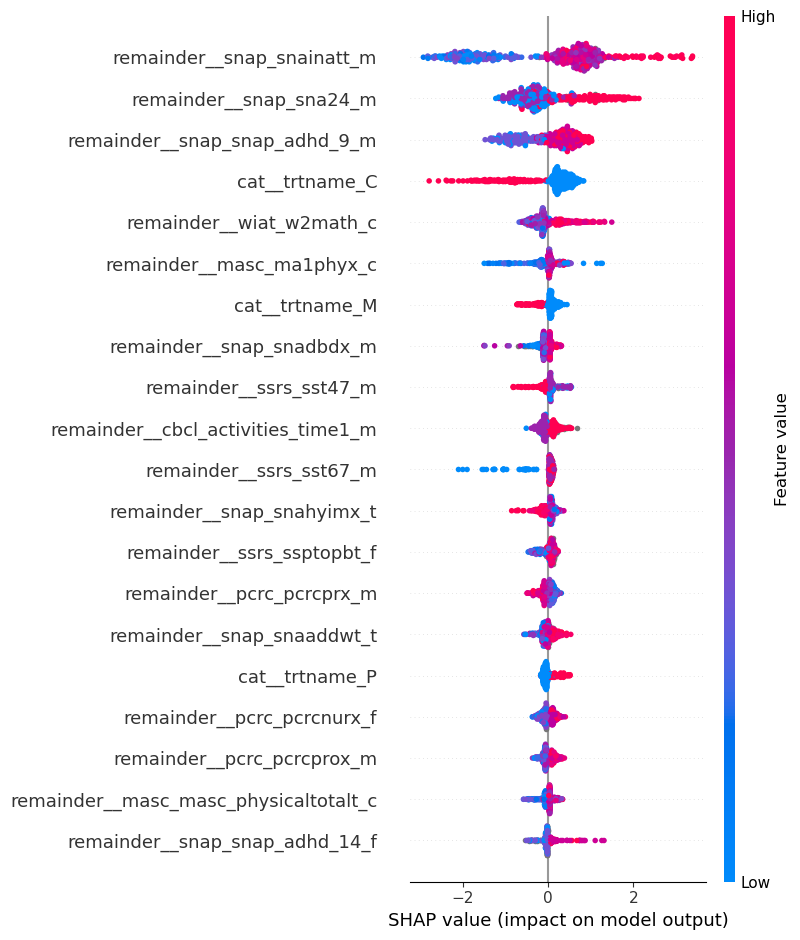

In [ ]:
shap.summary_plot(shap_vals, X_transformed, feature_names=preprocessor.get_feature_names_out())

In [ ]:
shap.force_plot(explainer.expected_value, shap_vals[0, :], X_transformed[0, :], feature_names=preprocessor.get_feature_names_out())

In [ ]:
feature_names = preprocessor.get_feature_names_out()

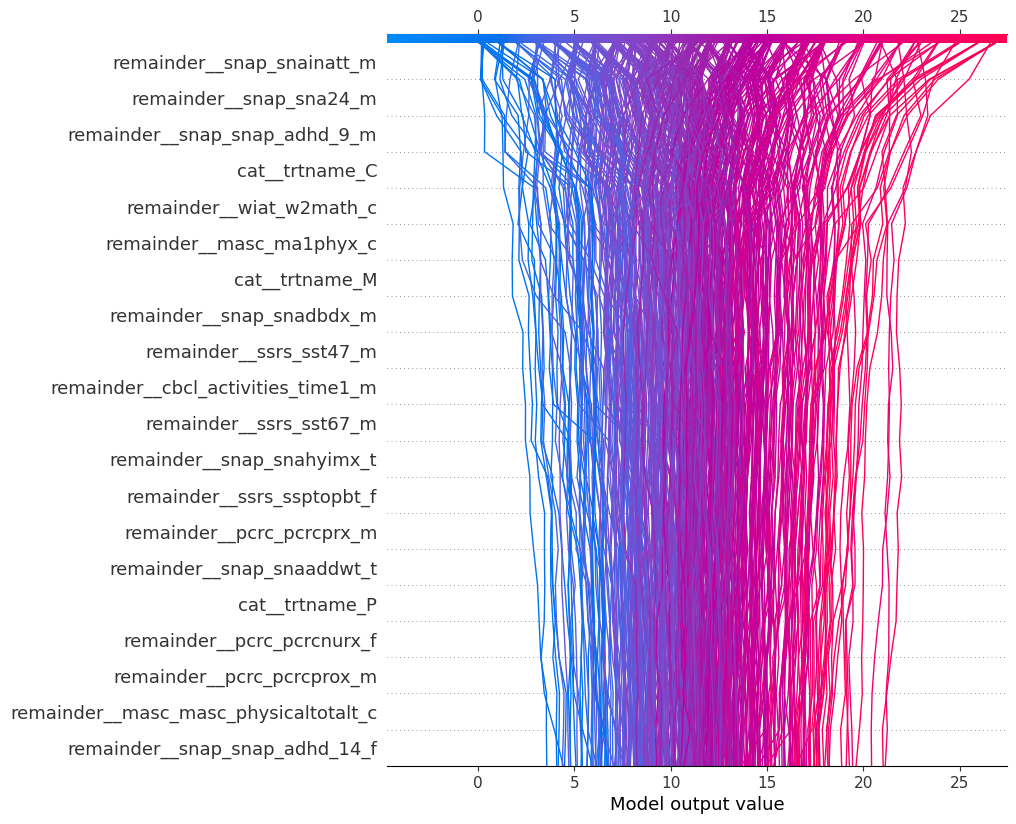

In [ ]:
shap.decision_plot(explainer.expected_value, shap_vals, X_transformed, feature_names=feature_names)

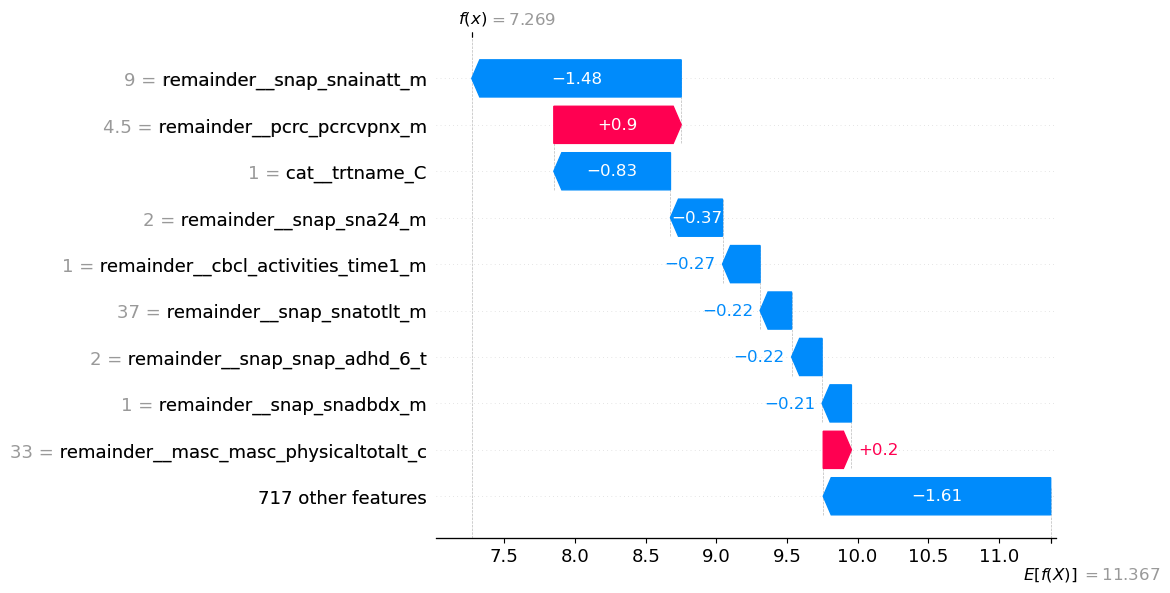

In [ ]:
shap.waterfall_plot(shap.Explanation(values=shap_vals[0], base_values=explainer.expected_value, data=X_transformed[0], feature_names=feature_names ))

In [ ]:
shap.heatmap(shap_vals)

AttributeError: module 'shap' has no attribute 'heatmap'